In [1]:
%matplotlib inline
from matplotlib import style, dates
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_, or_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

In [11]:
m_columns = inspector.get_columns("Measurement")
s_columns = inspector.get_columns("Station")

In [12]:
for column in m_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
for column in s_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
splitted_last_date = last_date[0].split("-")
year_of_last_date = int(splitted_last_date[0])
month_of_last_date = int(splitted_last_date[1])
day_of_last_date = int(splitted_last_date[2])

In [15]:
formatted_last_date = dt.date(year_of_last_date,month_of_last_date,day_of_last_date)
formatted_begin_date = formatted_last_date - dt.timedelta(days=365)
year_of_begin_date = formatted_begin_date.strftime("%Y")
month_of_begin_date = formatted_begin_date.strftime("%m")
day_of_begin_date = formatted_begin_date.strftime("%d")
begin_date = f"{year_of_begin_date}-{month_of_begin_date}-{day_of_begin_date}"
begin_date

'2016-08-23'

In [16]:
# Perform a query to retrieve the data and precipitation scores
stmt = session.query(Measurement).\
    filter(Measurement.date>=begin_date).order_by(Measurement.date).statement

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.read_sql_query(stmt, session.bind)
df = df.dropna()
df_short = df[["date","prcp"]]
df_short_groupedby = df_short.groupby("date").max()
df_short_groupedby.head()

,prcp
date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18


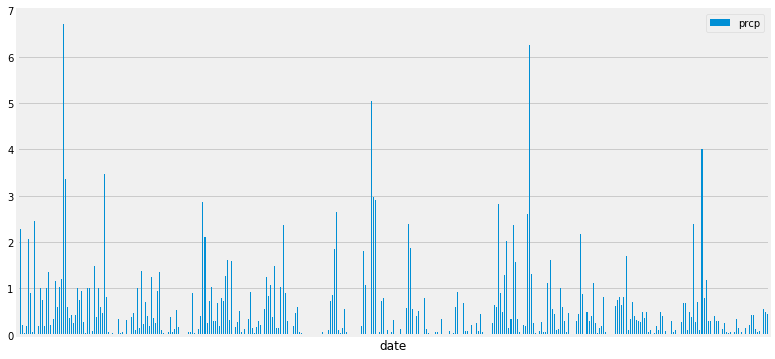

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
df_short_groupedby.plot(kind="bar",figsize=(12,6))
plt.gca().axes.get_xaxis().set_ticks([]) # using to hide x axis scale infoplt.tight_layout()
plt.savefig("../results/precipitation.png")
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_statistics = df[["prcp"]].describe()
prcp_statistics

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station=="USC00519281").all()


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

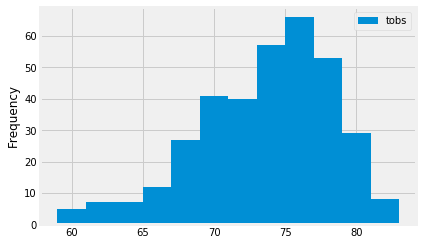

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stmt2 = session.query(Measurement).\
    filter(and_(Measurement.station=="USC00519281", Measurement.date>=begin_date)).order_by(Measurement.date).statement
df2 = pd.read_sql_query(stmt2, session.bind)
df2.dropna()
df2["tobs"].plot.hist(bins=12,legend="tobs")
plt.savefig("../results/temp_histogram.png")
plt.show()

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Since the begin and end dates are not clearly defined, I choose the time period between May 15 and Aug 15 in 2017.
temperatures = calc_temps('2017-05-15', '2017-08-15')

In [27]:
error = [temperatures[0][2]-temperatures[0][0]]
error

[19.0]

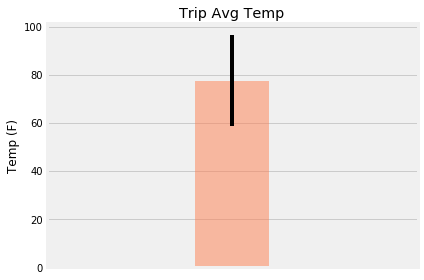

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = np.arange(len(temperatures))
ave_temp = [temperatures[0][1]]
error = [temperatures[0][2]-temperatures[0][0]]

plt.bar(x_pos, ave_temp, yerr=error,width=0.2, alpha=0.5,color="coral")
plt.xlim(-0.5,0.5)
plt.gca().axes.get_xaxis().set_ticks([]) # using to hide x axis scale info
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.tight_layout()
plt.savefig('../results/trip_avg_temp.png')
plt.show()